In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from time import sleep
import socket,time,requests
from bs4 import BeautifulSoup
import tkinter as tk

import yfinance as yf
import datetime




In [64]:
ticker='SOKM.IS'
start="2021-01-01"
end=str(datetime.date.today() +datetime.timedelta(days=1))
sokm=yf.download(ticker,start,end)


[*********************100%***********************]  1 of 1 completed


In [65]:
sokm

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,12.670000,13.000000,12.630000,12.990000,12.846131,8130734
2021-01-05,13.080000,13.450000,12.980000,13.180000,13.034028,21723960
2021-01-06,13.290000,13.350000,13.010000,13.040000,12.895577,9501027
2021-01-07,13.080000,13.220000,13.020000,13.080000,12.935135,7231038
2021-01-08,13.200000,14.150000,13.180000,13.990000,13.835056,35307250
...,...,...,...,...,...,...
2023-06-12,32.099998,32.419998,31.000000,31.100000,31.100000,6945177
2023-06-14,30.860001,31.260000,30.040001,30.639999,30.639999,5088918
2023-06-15,30.740000,31.900000,30.740000,31.900000,31.900000,4568659


In [66]:
close=pd.DataFrame(sokm["Close"])

close


,Close
Date,
2021-01-04,12.990000
2021-01-05,13.180000
2021-01-06,13.040000
2021-01-07,13.080000
2021-01-08,13.990000
...,...
2023-06-12,31.100000
2023-06-14,30.639999
2023-06-15,31.900000


In [67]:
rolling_app5=close.rolling(window=5).mean()
rolling_app14=close.rolling(window=15).mean()
rolling_app21=close.rolling(window=20).mean()



In [68]:
MAs=pd.concat([close,rolling_app5,rolling_app14,rolling_app21],axis=1)
MAs.columns=["Close","short","mid","long"]


In [69]:
MAs.dropna(axis=0,inplace=True)
MAs

,Close,short,mid,long
Date,,,,
2021-01-29,13.260000,13.856,13.948000,13.7750
2021-02-01,13.570000,13.716,13.904000,13.8040
2021-02-02,13.670000,13.604,13.878667,13.8285
2021-02-03,13.750000,13.616,13.855333,13.8640
2021-02-04,13.860000,13.622,13.856667,13.9030
...,...,...,...,...
2023-06-12,31.100000,30.932,28.864000,29.0380
2023-06-14,30.639999,31.096,28.962667,29.1070
2023-06-15,31.900000,31.312,29.240000,29.2020


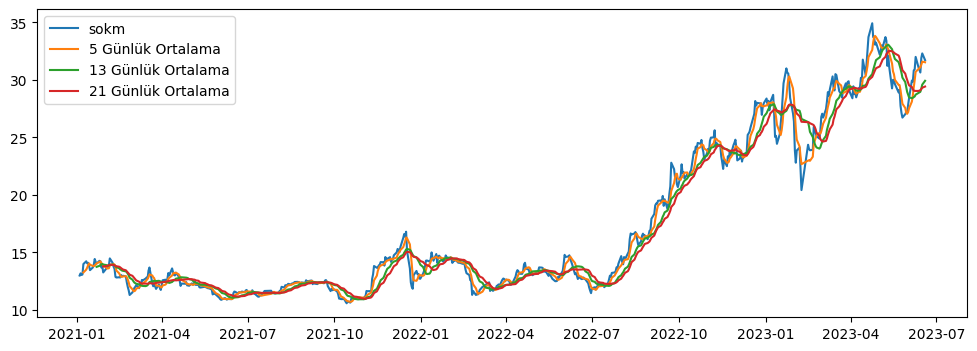

In [70]:
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(close.index,close,label='sokm')
ax.plot(rolling_app5.index,rolling_app5,label='5 Günlük Ortalama')
ax.plot(rolling_app14.index,rolling_app14,label='13 Günlük Ortalama')
ax.plot(rolling_app21.index,rolling_app21,label='21 Günlük Ortalama')
ax.legend(loc='upper left')


In [71]:
def buy_sell(data,perc=25):
    buy_sell=[]
    buy_signal=[]
    sell_signal=[]
    flag=42

    sm=np.abs(np.percentile(np.array(data["short"]-data["mid"]),perc))
    sl=np.abs(np.percentile(np.array(data["short"]-data["long"]),perc))

    for i in range(0,len(data)):
        if (data["short"][i]>data["mid"][i]+sm) & (data["short"][i]>data["long"][i]+sl):
            buy_signal.append(np.nan)
            if flag !=1:
                sell_signal.append(data["Close"][i])
                buy_sell.append(data["Close"][i])
                flag=1
            else:
                sell_signal.append(np.nan)
        elif (data["short"][i]<data["mid"][i]-sm)&(data["short"][i]<data["long"][i]-sl):
            sell_signal.append(np.nan)
            if flag!=0:
                buy_signal.append(data["Close"][i])
                buy_sell.append(-data["Close"][i])
                flag=0
            else:
                buy_signal.append(np.nan)
        else:
            buy_sell.append(np.nan)
            sell_signal.append(np.nan)
            buy_signal.append(np.nan)

    operations=np.array(buy_sell)
    operations=operations[~np.isnan(operations)]

    neg=0
    pos=0

    for i in range(len(operations)):
        if operations[i]<0:
            neg=i
            break
    for i in range(1,len(operations)):
        if operations[-i]>0:
            pos=i-1
            break
    operations=operations[neg:-pos]
    PL=np.sum(operations)

    return (buy_signal,sell_signal,PL)


In [72]:
m=buy_sell(MAs)
MAs["Al"]=m[0]
MAs["Sat"]=m[1]

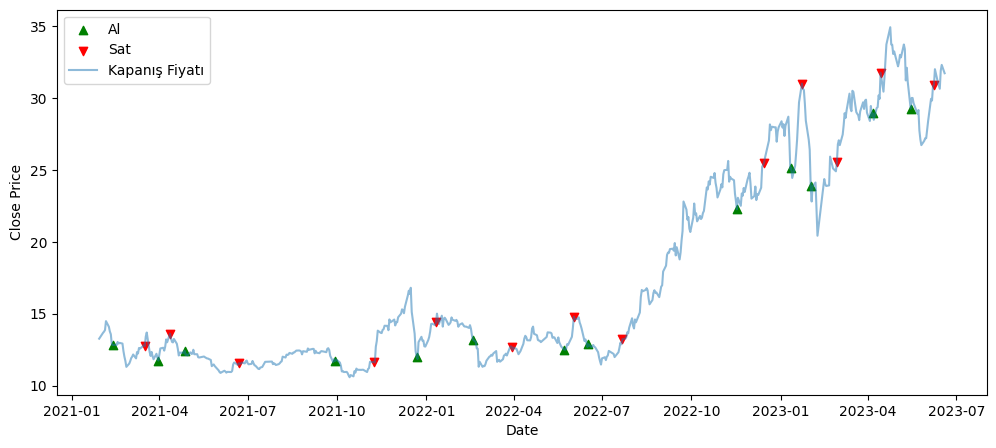

In [73]:
plt.figure(figsize=(12,5))
plt.scatter(MAs.index,MAs["Al"],color="green",label='Al',marker='^',alpha=1)
plt.scatter(MAs.index,MAs["Sat"],color="red",label='Sat',marker='v',alpha=1)
plt.plot(MAs["Close"],label='Kapanış Fiyatı',alpha=0.5)
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend(loc='upper left')
plt.show()

In [74]:
al=MAs["Al"]
al=al.dropna(axis=0)
al

Date
2021-02-12    12.820000
2021-03-31    11.740000
2021-04-27    12.420000
2021-09-29    11.710000
2021-12-22    12.010000
2022-02-18    13.200000
2022-05-23    12.500000
2022-06-17    12.870000
2022-11-17    22.260000
2023-01-12    25.139999
2023-02-01    23.879999
2023-04-06    28.920000
2023-05-15    29.260000
Name: Al, dtype: float64

In [75]:
sat=MAs["Sat"]
sat=sat.dropna(axis=0)
sat


Date
2021-03-17    12.750000
2021-04-12    13.610000
2021-06-22    11.550000
2021-11-08    11.640000
2022-01-11    14.390000
2022-03-30    12.690000
2022-06-02    14.790000
2022-07-22    13.220000
2022-12-15    25.500000
2023-01-23    31.000000
2023-02-28    25.540001
2023-04-14    31.760000
2023-06-08    30.920000
Name: Sat, dtype: float64

In [54]:
del sat["2020-07-03"]

In [76]:
sat_val=sat.values
al_val=al.values


In [77]:
sat_val1=sat_val

In [78]:
sat_val1

array([12.75      , 13.60999966, 11.55000019, 11.64000034, 14.39000034,
       12.68999958, 14.78999996, 13.22000027, 25.5       , 31.        ,
       25.54000092, 31.76000023, 30.92000008])

In [79]:
al_val1=al_val
al_val1

array([12.81999969, 11.73999977, 12.42000008, 11.71000004, 12.01000023,
       13.19999981, 12.5       , 12.86999989, 22.26000023, 25.13999939,
       23.87999916, 28.92000008, 29.26000023])

In [80]:
res=[]

for i in range(len(al_val1)):
    res.append((sat_val1[i]/al_val1[i]))

In [81]:
df=pd.DataFrame()
df["Kar"]=res
df

,Kar
0,0.994540
1,1.159284
2,0.929952
3,0.994022
4,1.198168
5,0.961364
6,1.183200
7,1.027195
8,1.145553
9,1.233095


In [82]:
res0=[100]
for i in range(13):
    res0.append(res0[i]*df["Kar"].loc[i])


In [83]:
df["Eldeki Para"]=res0[1:]
df

,Kar,Eldeki Para
0,0.994540,99.453981
1,1.159284,115.295457
2,0.929952,107.219206
3,0.994022,106.578275
4,1.198168,127.698699
5,0.961364,122.764884
6,1.183200,145.255410
7,1.027195,149.205639
8,1.145553,170.922900
9,1.233095,210.764122


In [84]:
karlilik=df["Eldeki Para"].iloc[-1]/100
karlilik=(karlilik-1)*100
print("Karlılık oranı %",karlilik)

Karlılık oranı % 161.59573193198443


## Her sat tavsiyesinde satmayıp 2.sat tavsiyesinde satarsak ne olur?(Yani 1 adet sat tavsiyesini pas geçersek)

In [85]:
sat_val2=sat_val[1:13:2]

In [86]:
sat_val2

array([13.60999966, 11.64000034, 12.68999958, 13.22000027, 31.        ,
       31.76000023])

In [87]:
al_val2=al_val[0:12:2]
al_val2

array([12.81999969, 12.42000008, 12.01000023, 12.5       , 22.26000023,
       23.87999916])

In [88]:
res1=[]

for i in range(6):
    res1.append((sat_val2[i]/al_val2[i]))

In [89]:
df1=pd.DataFrame()
df1["Kar"]=res1
df1

,Kar
0,1.061622
1,0.937198
2,1.056619
3,1.057600
4,1.392633
5,1.329983


In [90]:
res2=[100]
for i in range(6):
    res2.append(res2[i]*df1["Kar"].loc[i])




In [91]:
df1["Eldeki Para"]=res2[1:]
df1


,Kar,Eldeki Para
0,1.061622,106.162246
1,0.937198,99.495054
2,1.056619,105.128408
3,1.057600,111.183806
4,1.392633,154.838183
5,1.329983,205.932199


In [92]:
karlilik=df1["Eldeki Para"].iloc[-1]/100
karlilik=(karlilik-1)*100
print("Karlılık oranı %",karlilik)

Karlılık oranı % 105.93219853183724
